In [187]:
import numpy as np
import scipy.spatial as spt
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
import pandas as pd

def kmeans(X,
           eta=0.1,
           n_clusters=1,
           n_iter=1,
           max_iter=100,
           tol=1e-6,
           random_state=None):
    np.random.seed(random_state)
    
    # Initialize centroids to n_clusters random data points
    centroids = X[np.random.choice(X.shape[0], n_clusters, replace=False)]
    
    for i in range(max_iter):
        # Calculate the distance between each data point and centroid
        distances = spt.distance.cdist(X, centroids, 'euclidean')
        
        # Calculate the index of the closest centroid
        fit = np.argmin(distances, axis=1)
        
        # Update the centroid values
        for k in range(n_clusters):
            for n in range(X.shape[1]):
                centroids[k][n] = centroids[k][n] + eta * (np.mean(X[k == fit][:,n]) - centroids[k][n])
    return fit, centroids


def gaussianMixture(X,
                    eta=0.1,
                    n_components=1,
                    tol=1e-6,
                    max_iter=100,
                    n_init=10,
                    means_init=None,
                    random_state=None):

    # Extract data dimensionality
    N = X.shape[0]
    D = X.shape[1]
    
    # Initialize means
    if means_init is None:
        y_km, Mu = kmeans(X, eta=eta, n_clusters=n_components, random_state=random_state)
    else:
        Mu = means_init
        
    # Initialize covariances
    Sigma = np.ones([n_components, D, D])
    for i in range(n_components):
        Sigma[i] = np.eye(D)

    # Initialize mixing coefficients
    Pi = np.ones([n_components, 1])/n_components
    
    # Initialize log likelihood
    LL = getLogLikelihood(X, Mu, Sigma, Pi, n_components, N)
    
    # Allocate for the responsibilities
    Gamma = np.zeros([N, n_components])
    
    for count in range(max_iter):
        Pi_new = np.copy(Pi)
        Mu_new = np.copy(Mu)
        Sigma_new = np.copy(Sigma)
        
        # Evaluate
        for i in range(N):
            for j in range(n_components):
                Gamma[i,j] = Pi[j] * Gaussian(X[i,:], Mu[j,:], Sigma[j,:,:])
            Gamma[i,:] = Gamma[i,:] / np.sum(Gamma[i,:])
    
        # Update Mu
        N_k = Gamma.sum(axis=0).T
        for k in range(n_components):
            for i in range(D):
                Mu_new[k,i] = np.sum(Gamma[:,k]*X[:,i]) / N_k[k]
                

        # Update Sigma
        for k in range(n_components):
            Sigma_new[k,:,:] = np.zeros([D,D])
            for i in range(N):
                temp = (X[i,:] - Mu_new[k,:]).reshape((2,1))
                Sigma_new[k,:,:] += Gamma[i,k]*np.dot(temp,temp.T)/N_k[k]

        # Update Pi
        Pi_new = N_k/N
        
        # Update log likelihood
        LL_new = getLogLikelihood(X, Mu_new, Sigma_new, Pi_new, n_components, N)
        
        if checkConvergance(Mu, Mu_new, Sigma, Sigma_new, Pi, Pi_new, LL, LL_new, tol):
            print('Convergence reached')
            break
        else:
            LL = np.copy(LL_new)
            Pi = np.copy(Pi_new)
            Mu = np.copy(Mu_new)
            Sigma = np.copy(Sigma_new)
            
    
    fit = np.argmax(Gamma,axis=1)
    return fit, Mu
    
    
def Gaussian(X, Mu, Sigma):
    return float ((2*np.pi*np.linalg.det(Sigma))**(-0.5) * 
                  np.exp( -0.5*np.dot(np.dot((X-Mu),np.linalg.pinv(Sigma)), (X-Mu).T)) )

def getLogLikelihood(X, Mu, Sigma, Pi, n_components, N):
    ret = 0.0
    for i in range(N):
        temp = 0.0
        for k in range(n_components):
            temp += Pi[k] * Gaussian(X[i,:], Mu[k,:], Sigma[k,:,:])
        ret += np.log(temp)
        
    return ret

def checkConvergance(Mu, Mu_new, Sigma, Sigma_new, Pi, Pi_new, LL, LL_new, tol):
    done = False
    done = done or np.any(np.abs(Mu - Mu_new) <= tol)
    done = done or np.any(np.abs(Sigma - Sigma_new) <= tol)
    done = done or np.any(np.abs(Pi - Pi_new) <= tol)
    return done

In [192]:
X, y = make_blobs(n_samples=150,
                  n_features=2,
                  centers=3,
                  cluster_std=[0.3,0.6,0.5],
                  shuffle=True,
                  random_state=0)
print(X[0:5,:])
print(y)

[[ 2.71506328  1.2908219 ]
 [ 0.70993435  3.70954839]
 [ 0.87189643  4.35069202]
 [ 0.70763011  4.41985808]
 [ 2.73124907  0.24970475]]
[1 0 0 0 1 0 0 1 2 0 1 2 2 0 0 2 2 1 2 1 0 1 0 0 2 1 1 0 2 1 2 2 2 2 0 1 1
 1 0 0 2 2 0 1 1 1 2 0 2 0 1 0 0 1 1 2 0 1 2 0 2 2 2 2 0 2 0 1 0 0 0 1 1 0
 1 0 0 2 2 0 1 1 0 0 1 1 1 2 2 1 1 0 1 0 1 0 2 2 1 1 1 1 2 1 1 0 2 0 0 0 2
 0 1 2 0 2 0 0 2 2 0 1 0 0 1 1 2 1 2 2 2 2 1 2 2 2 0 2 1 2 0 0 1 1 2 2 2 2
 1 1]


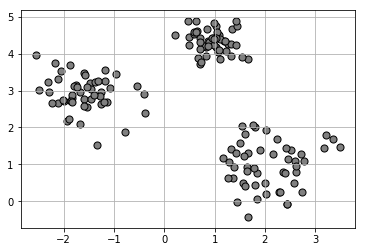

In [193]:
plt.clf()
plt.scatter(X[:, 0],
            X[:, 1],
            c=[0.5,0.5,0.5],
            marker='o',
            edgecolors='black',
            s=50)
plt.grid()
plt.show()

In [194]:
y_km, centroids_km = kmeans(X, eta=0.1, n_clusters=3, random_state=0)
print("y_km =\n", y_km)
print("centroids_km =\n", centroids_km)

y_km =
 [1 0 0 0 1 0 0 1 2 0 1 2 2 0 0 2 2 1 2 1 0 1 0 0 2 1 1 0 2 1 2 2 2 2 0 1 1
 1 0 0 2 2 0 1 1 1 2 0 2 0 1 0 0 1 1 2 0 1 2 0 2 2 2 2 0 2 0 1 0 0 0 1 1 0
 1 0 0 2 2 0 1 1 0 0 1 1 1 2 2 1 1 0 1 0 1 0 2 2 1 1 1 1 2 1 1 0 2 0 0 0 2
 0 1 2 0 2 0 0 2 2 0 1 0 0 1 1 2 1 2 2 2 2 1 2 2 2 0 2 1 2 0 0 1 1 2 2 2 2
 1 1]
centroids_km =
 [[ 0.95030937  4.33401232]
 [ 2.06704246  0.97418652]
 [-1.59474542  2.92238621]]


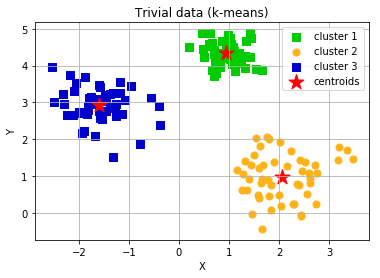

In [199]:
plt.clf()
plt.scatter(X[y_km==0, 0],
            X[y_km==0, 1],
            s=50,
            c=[0, 0.8, 0],
            marker='s',
            label='cluster 1')
plt.scatter(X[y_km==1, 0],
            X[y_km==1, 1],
            s=50,
            c=[1, 0.7, 0.1],
            marker='o',
            label='cluster 2')
plt.scatter(X[y_km==2, 0],
            X[y_km==2, 1],
            s=50,
            c=[0, 0, 0.8],
            marker='s',
            label='cluster 3')
plt.scatter(centroids_km[:, 0],
            centroids_km[:, 1],
            s=250,
            marker='*',
            c='red',
            label='centroids')
plt.legend()
plt.grid()
plt.title('Trivial data (k-means)')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()


In [200]:
y_gmm, centroids_gmm = gaussianMixture(X, eta=0.1, n_components=3, means_init=centroids_km, random_state=0)
print("y_gmm =\n", y_gmm)
print("centroids_gmm =\n", centroids_gmm)

Convergence reached
y_gmm =
 [1 0 0 0 1 0 0 1 2 0 1 2 2 0 0 2 2 1 2 1 0 1 0 0 2 1 1 0 2 1 2 2 2 2 0 1 1
 1 0 0 2 2 0 1 1 1 2 0 2 0 1 0 0 1 1 2 0 1 2 0 2 2 2 2 0 2 0 1 0 0 0 1 1 0
 1 0 0 2 2 0 1 1 0 0 1 1 1 2 2 1 1 0 1 0 1 0 2 2 1 1 1 1 2 1 1 0 2 0 0 0 2
 0 1 2 0 2 0 0 2 2 0 1 0 0 1 1 2 1 2 2 2 2 1 2 2 2 0 2 1 2 0 0 1 1 2 2 2 2
 1 1]
centroids_gmm =
 [[ 0.94982569  4.33361905]
 [ 2.06719567  0.97412964]
 [-1.59503501  2.92237142]]


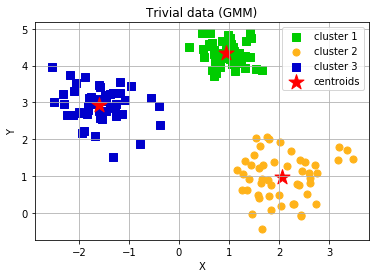

In [201]:
plt.clf()
plt.scatter(X[y_gmm==0, 0],
            X[y_gmm==0, 1],
            s=50,
            c=[0, 0.8, 0],
            marker='s',
            label='cluster 1')
plt.scatter(X[y_gmm==1, 0],
            X[y_gmm==1, 1],
            s=50,
            c=[1, 0.7, 0.1],
            marker='o',
            label='cluster 2')
plt.scatter(X[y_gmm==2, 0],
            X[y_gmm==2, 1],
            s=50,
            c=[0, 0, 0.8],
            marker='s',
            label='cluster 3')
plt.scatter(centroids_gmm[:, 0],
            centroids_gmm[:, 1],
            s=250,
            marker='*',
            c='red',
            label='centroids')
plt.legend()
plt.grid()
plt.title('Trivial data (GMM)')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

y_km =
 [1 0 1 0 1 0 0 1 0 1 0 0 1 0 1 1 0 1 0 1 1 0 0 0 0 1 0 0 0 0 0 1 0 0 1 1 0
 1 0 0 1 0 1 0 0 1 1 0 1 0 0 1 0 1 0 0 1 0 0 1 0 1 0 1 0 0 0 1 0 0 1 0 0 1
 0 1 0 0 0 0 0 0 1 0 0 0 0 1 0 1 0 1 0 1 0 0 0 1 0 1 0 1 0 0 1 0 1 0 0 0 1
 0 0 1 0 1 0 1 0 1 0 0 1 0 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 0 0 1 0 1 0
 1 0 0 1 0 0 0 0 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 0 0 0 0 1 0 0 1 0 0 0 1 0
 0 1 0 1 0 1 0 0 0 0 0 0 1 0 1 0 0 1 0 1 0 0 1 0 0 0 1 0 1 0 1 0 1 0 1 0 1
 0 0 0 0 0 0 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 0 0 0 0 0 1 0
 0 0 1 0 1 1 0 0 1 0 1 0]
centroids_km =
 [[  4.3021514   80.29571545]
 [  2.09503052  54.75692027]]


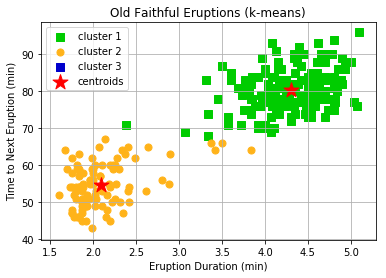

In [203]:
df = pd.read_csv('Data/oldFaithful.csv',sep=',');

X = df.as_matrix()
y_km, centroids_km = kmeans(X, eta=0.1, n_clusters=2, random_state=0)
print("y_km =\n", y_km)
print("centroids_km =\n", centroids_km)

plt.clf()
plt.scatter(X[y_km==0, 0],
            X[y_km==0, 1],
            s=50,
            c=[0, 0.8, 0],
            marker='s',
            label='cluster 1')
plt.scatter(X[y_km==1, 0],
            X[y_km==1, 1],
            s=50,
            c=[1, 0.7, 0.1],
            marker='o',
            label='cluster 2')
plt.scatter(X[y_km==2, 0],
            X[y_km==2, 1],
            s=50,
            c=[0, 0, 0.8],
            marker='s',
            label='cluster 3')
plt.scatter(centroids_km[:, 0],
            centroids_km[:, 1],
            s=250,
            marker='*',
            c='red',
            label='centroids')
plt.legend()
plt.grid()
plt.title('Old Faithful Eruptions (k-means)')
plt.xlabel('Eruption Duration (min)')
plt.ylabel('Time to Next Eruption (min)')
plt.show()

Convergence reached
y_gmm =
 [1 0 1 0 1 0 0 1 0 1 0 0 1 0 1 1 0 1 0 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 1 1 0
 1 0 0 1 0 1 0 0 0 1 0 1 0 0 1 0 1 0 0 1 0 0 1 0 1 0 1 0 0 0 1 0 0 1 0 0 1
 0 1 0 0 0 0 0 0 1 0 0 0 0 1 0 1 0 1 0 1 0 0 0 1 0 1 0 1 0 0 1 0 1 0 0 0 1
 0 0 1 0 1 0 1 0 1 0 0 1 0 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 0 0 1 0 1 0
 1 0 0 1 0 0 0 0 0 1 0 1 0 1 0 0 0 1 0 1 0 1 1 0 0 0 0 0 1 0 0 1 0 0 0 1 0
 0 1 0 1 0 1 0 0 0 0 0 0 1 0 1 0 0 1 0 1 0 0 1 0 1 0 1 0 0 0 1 0 1 0 1 0 1
 0 0 0 0 0 0 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 0 0 0 0 0 1 0
 0 0 1 0 1 1 0 0 1 0 1 0]
centroids_gmm =
 [[  4.29373688  79.97502685]
 [  2.03651546  54.47987041]]


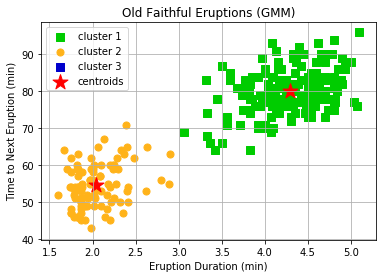

In [204]:
y_gmm, centroids_gmm = gaussianMixture(X, eta=0.1, n_components=2, means_init=centroids_km, random_state=0)
print("y_gmm =\n", y_gmm)
print("centroids_gmm =\n", centroids_gmm)

plt.clf()
plt.scatter(X[y_gmm==0, 0],
            X[y_gmm==0, 1],
            s=50,
            c=[0, 0.8, 0],
            marker='s',
            label='cluster 1')
plt.scatter(X[y_gmm==1, 0],
            X[y_gmm==1, 1],
            s=50,
            c=[1, 0.7, 0.1],
            marker='o',
            label='cluster 2')
plt.scatter(X[y_gmm==2, 0],
            X[y_gmm==2, 1],
            s=50,
            c=[0, 0, 0.8],
            marker='s',
            label='cluster 3')
plt.scatter(centroids_gmm[:, 0],
            centroids_gmm[:, 1],
            s=250,
            marker='*',
            c='red',
            label='centroids')
plt.legend()
plt.grid()
plt.title('Old Faithful Eruptions (GMM)')
plt.xlabel('Eruption Duration (min)')
plt.ylabel('Time to Next Eruption (min)')
plt.show()